In [34]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

from scipy import constants as c
c.Msun = 1.989e30

from pycbc import fft, types
from pycbc.waveform import get_fd_waveform, get_td_waveform, fd_approximants, apply_fd_time_shift
from pycbc.waveform.utils import fd_to_td

from copy import deepcopy
import joblib

import sys
sys.path.append("../")
import GSHEWaveform

# Functions to turn on and off custom plotting
def default_mplstyle():
    mpl.rcParams.update(mpl.rcParamsDefault)
    
def custom_mplstyle():
    mpl.style.use("../plot_style.txt")
    
def ylabel_with_offset(ax, label):
    ax.yaxis.offsetText.set_visible(False)
    offset = ax.yaxis.get_major_formatter().get_offset()
    ax.set_ylabel(r"{} {}".format(label, offset))
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
f_min = 40
f_max = 1024
M = 5e4

<IPython.core.display.Javascript object>


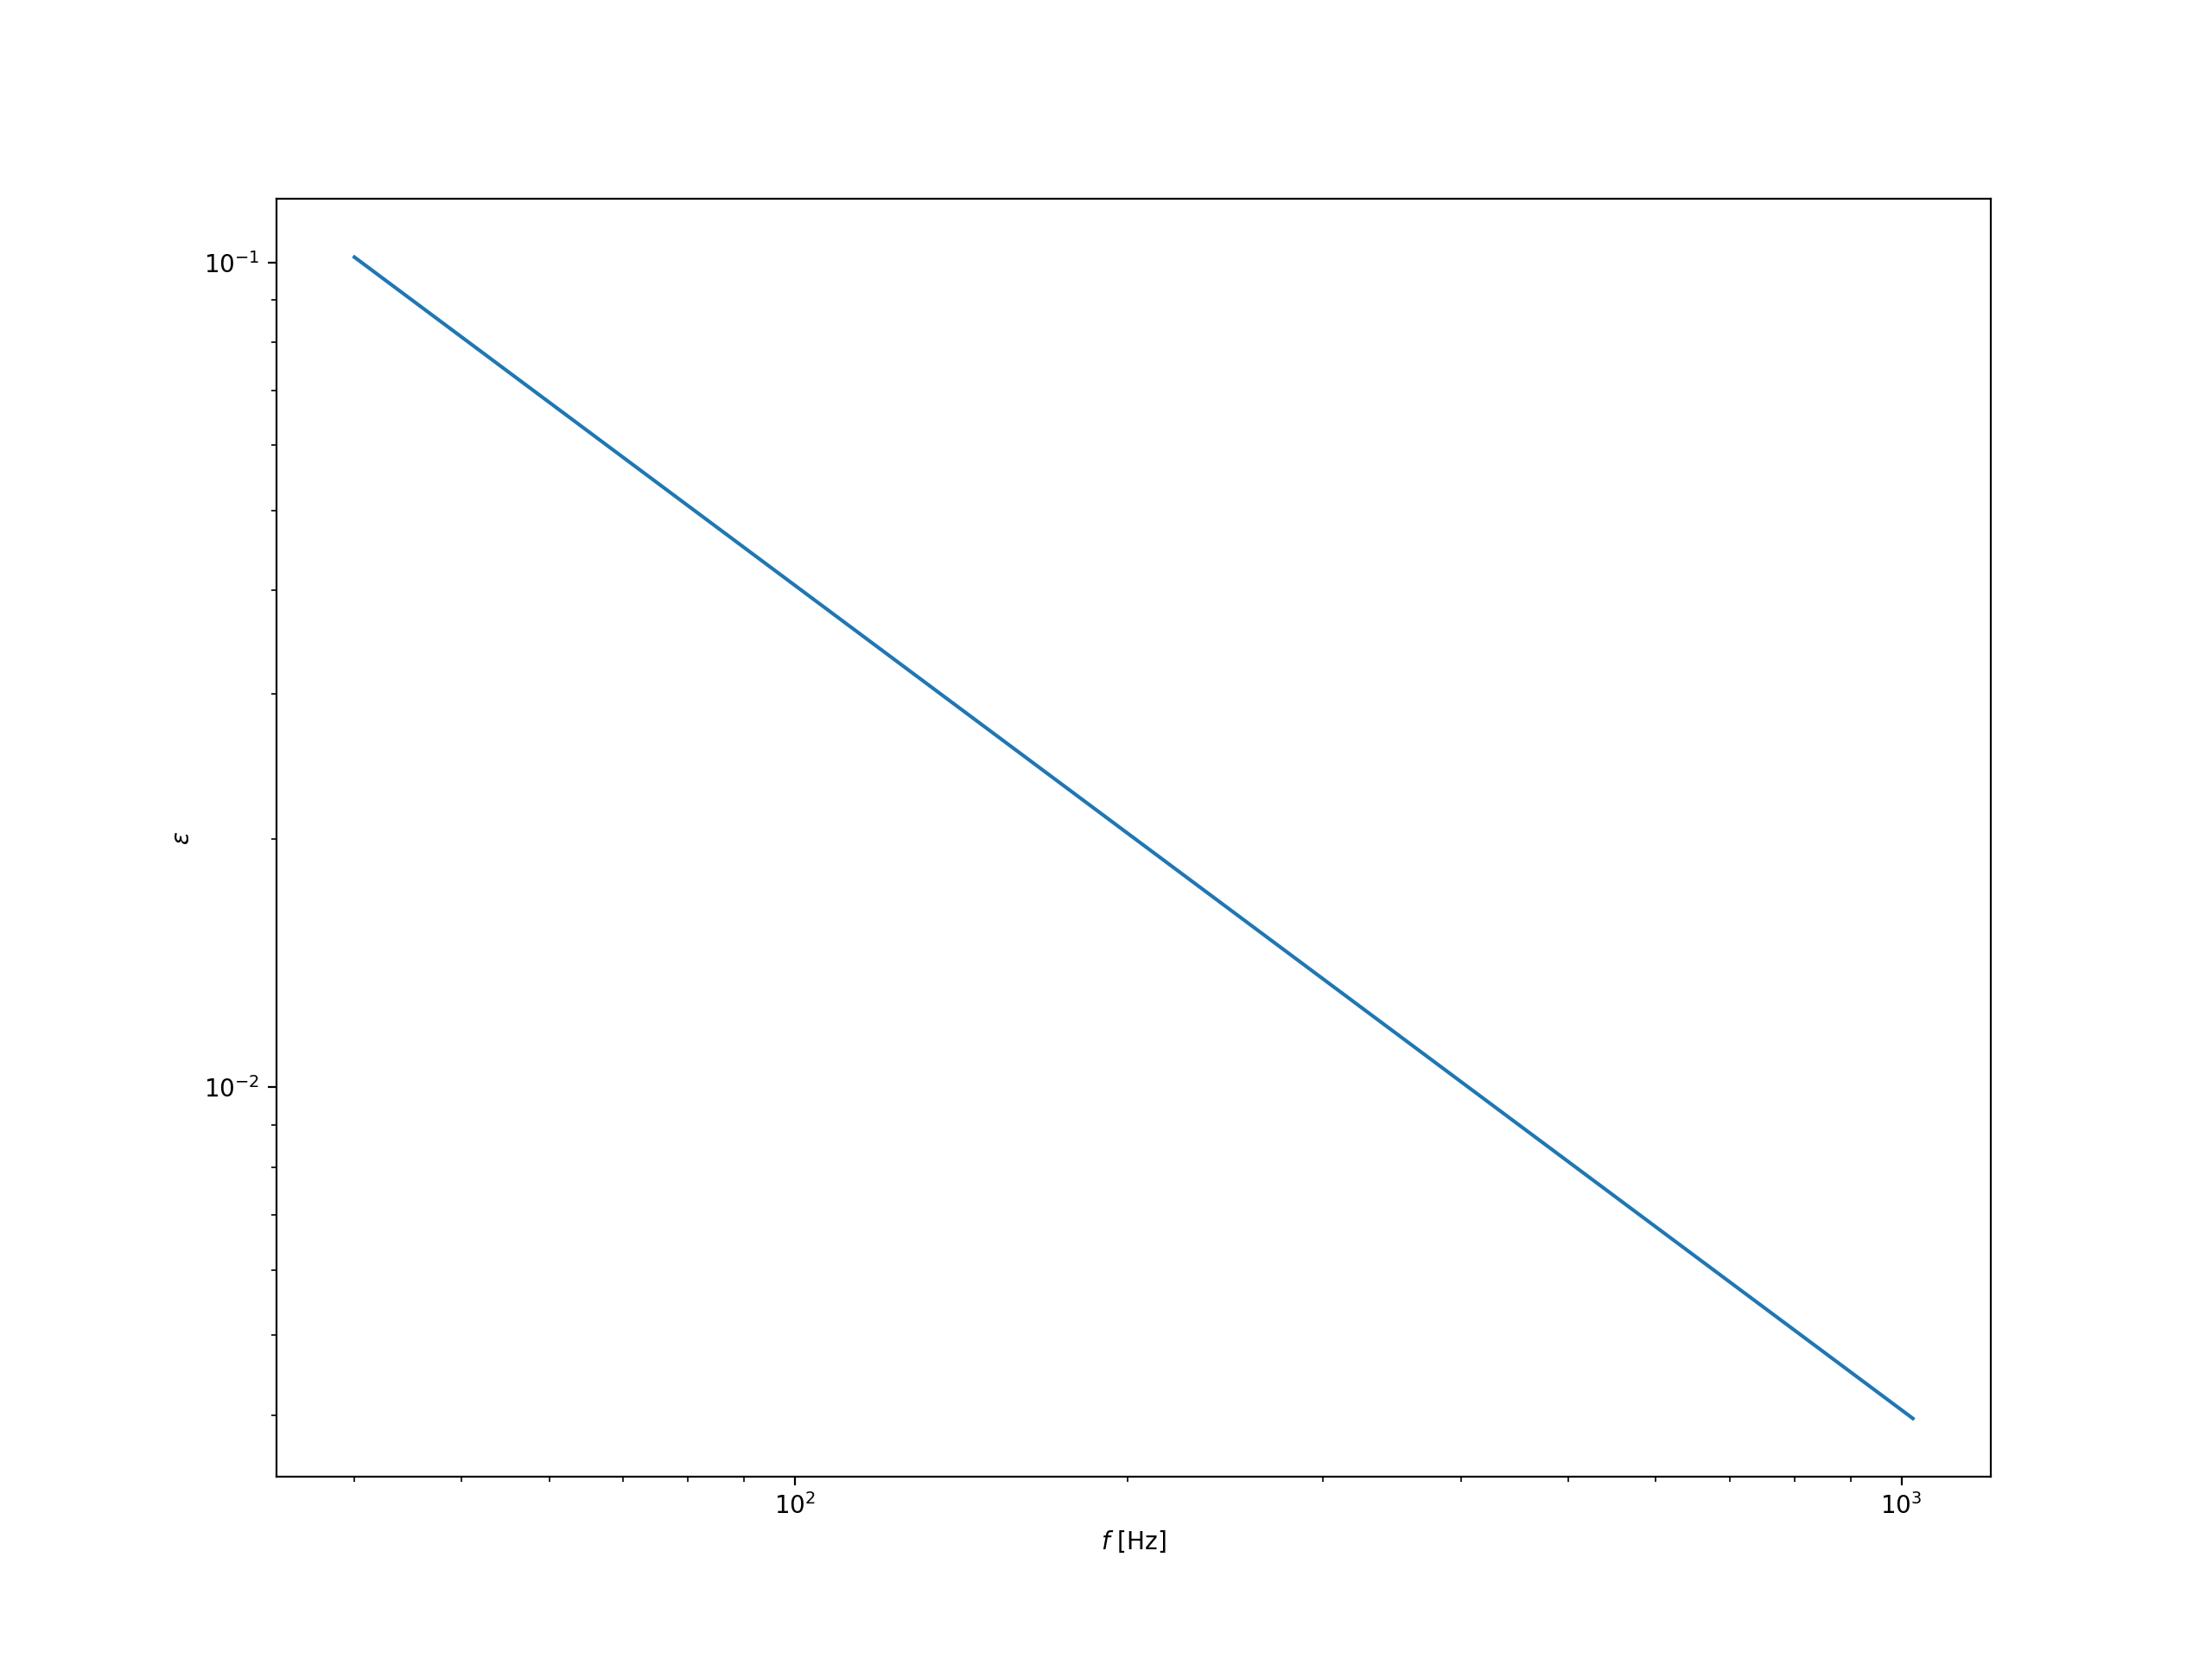

In [3]:
fs = np.linspace(f_min, f_max, 1000)

plt.figure()
plt.plot(fs, GSHEWaveform.epsilon_from_freq(fs, M))
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$f~[\mathrm{Hz}]$")
plt.ylabel(r"$\epsilon$")
plt.show()

In [72]:
waveform_params = {"approximant": "IMRPhenomXP", "mass1": 25, "mass2": 15, "spin1z": 0.7,
                   "inclination": 0.9*np.pi}

delta_f = 0.001
left_taper = 10
right_taper = 100

left_window = (f_min - left_taper, f_min)
right_window = (f_max, f_max + right_taper)

fhplus, fhcross = get_fd_waveform(**waveform_params, delta_f=delta_f, f_lower=f_min - left_taper,
                                  f_final=f_max+right_taper)

Functions that calculate the time delay for a given frequency. For now assume a simple analytic expression (power law). Later take data and interpolate between sampled data points.

In [73]:
runID = "01"

Xgeos = np.load("../data/{}Xgeos.npy".format(runID))
Xgshes = np.load("../data/{}Xgshes.npy".format(runID))
vary_param = np.load("../data/{}VaryParam.npy".format(runID))
epsilons = np.load("../data/{}Epsilons.npy".format(runID))

k = np.abs(vary_param - 0.4*np.pi).argmin()

Xgeo = Xgeos[k, ...]
Xgshe = Xgshes[k, ...]

In [74]:
n = 0
rdelay = GSHEWaveform.GSHEtoGeodesicDelayInterpolator(epsilons, Xgshe, Xgeo, n, s=0, M=M)
ldelay = GSHEWaveform.GSHEtoGeodesicDelayInterpolator(epsilons, Xgshe, Xgeo, n, s=1, M=M)

# rdelay = lambda f: GSHEWaveform.time_delay_analytical(
#     f, M, GSHEWaveform.coordinate_time_to_seconds(5, M), 2.0)
# ldelay = lambda f: GSHEWaveform.time_delay_analytical(
#     f, M, GSHEWaveform.coordinate_time_to_seconds(5, M), 2.0)

<IPython.core.display.Javascript object>


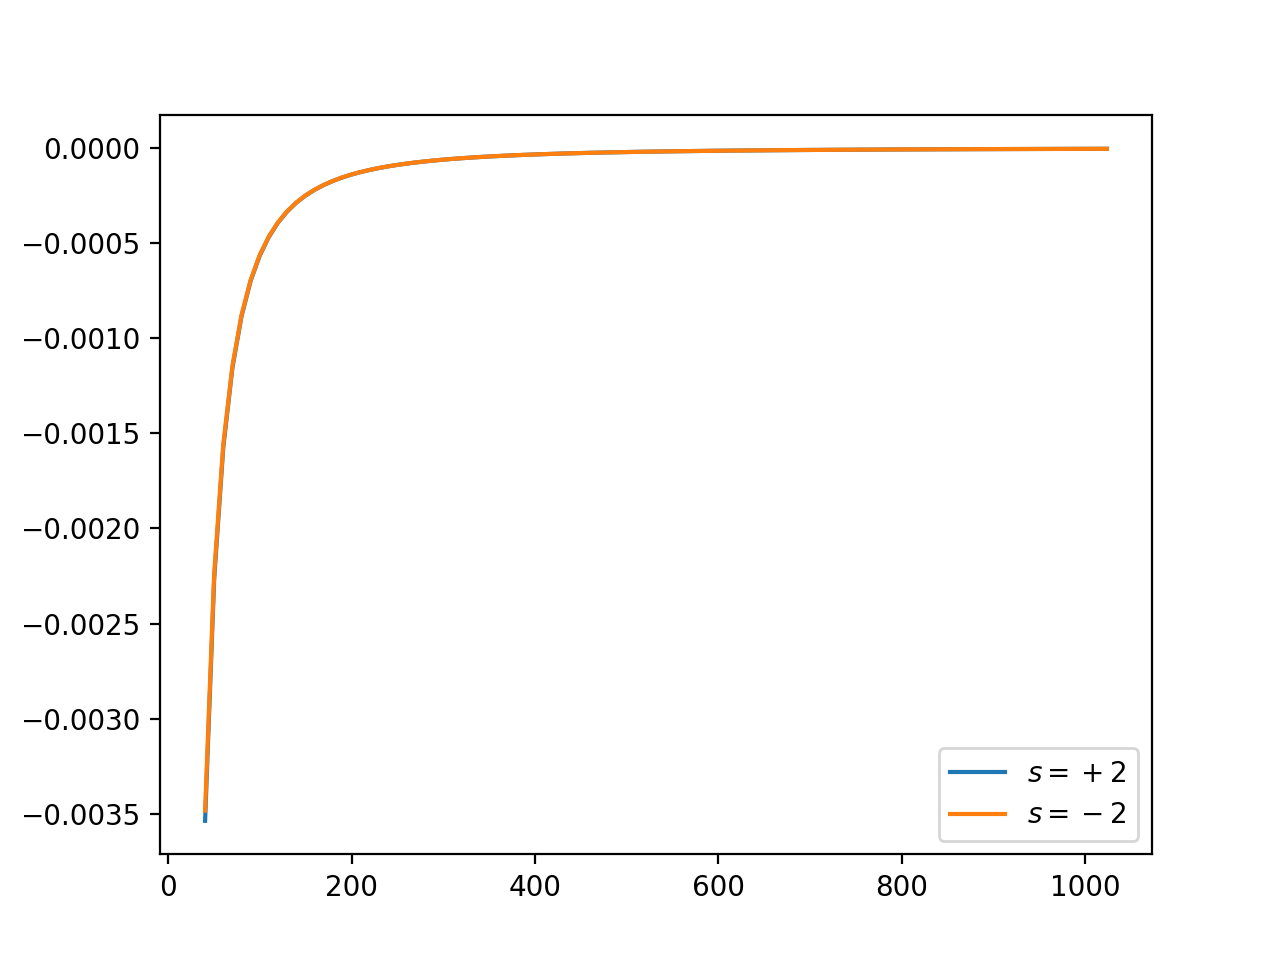

In [75]:
default_mplstyle()

fs = np.linspace(f_min, f_max, 100)
plt.figure()
plt.plot(fs, rdelay(fs), label=r"$s=+2$")
plt.plot(fs, ldelay(fs), label=r"$s=-2$")

# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.show()

Apply the GSHE corrections to the generated waveform in the frequency domain

In [76]:
fhplus_gshe, fhcross_gshe = GSHEWaveform.gshe_to_linear(fhplus, fhcross, rdelay, ldelay)

/Users/richard/Projects/birefringence/paper_plots/../GSHEWaveform/utils.py:46: RuntimeWarning: divide by zero encountered in true_divide
  return c.c**3 / (c.G * c.Msun) / M / f


Inverse Fourier transform to the time domain

In [77]:
# Plus polarisation
thplus = GSHEWaveform.fd_to_td_fiducialshift(fhplus, left_window, right_window)
thplus_gshe = GSHEWaveform.fd_to_td_fiducialshift(fhplus_gshe, left_window, right_window)

# Cross polarisation
thcross = GSHEWaveform.fd_to_td_fiducialshift(fhcross, left_window, right_window)
thcross_gshe = GSHEWaveform.fd_to_td_fiducialshift(fhcross_gshe, left_window, right_window)

# Plot of the + polarisation state

<IPython.core.display.Javascript object>


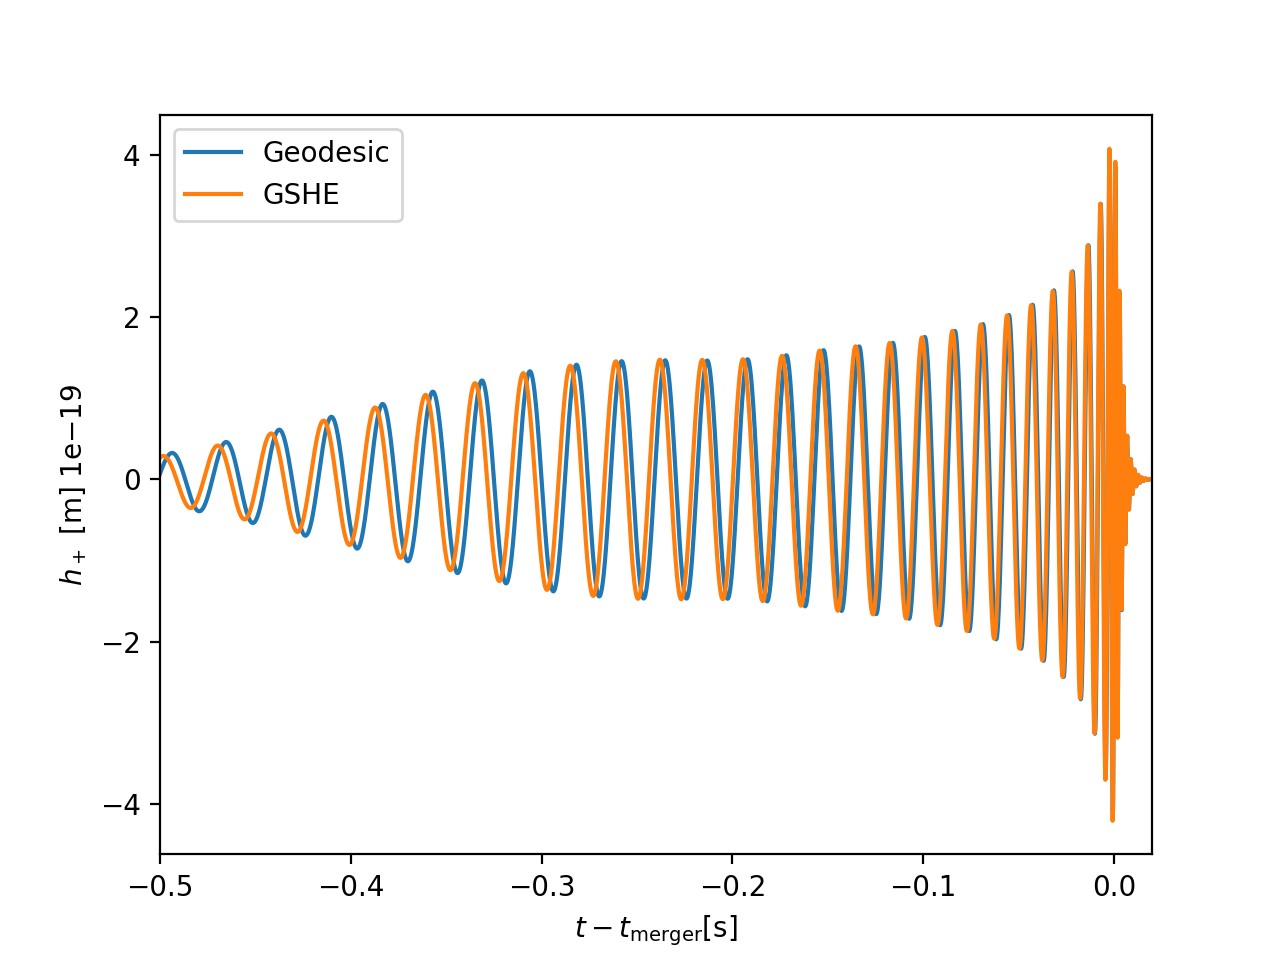

In [82]:
default_mplstyle()

fig, ax = plt.subplots()

ax.plot(thplus.sample_times, thplus.data, label="Geodesic")
ax.plot(thplus_gshe.sample_times, thplus_gshe.data, label="GSHE")

plt.savefig("/Users/richard/Downloads/_tmp.png")

ax.legend()
ax.set_xlabel(r"$t - t_{\rm merger} [\mathrm{s}]$")
ax.set_ylabel(r"$h_{\rm +} [\mathrm{m}]$")
ax.set_xlim(-0.5, 0.02)
ylabel_with_offset(ax, r"$h_{\rm +}~[\mathrm{{m}}]$")
# plt.savefig("/Users/richard/Downloads/hp_example.pdf", bbox_inches="tight")
fig.show()

In [83]:
out = {"thplus": thplus,
      "thcross": thcross,
      "thplus_gshe": thplus_gshe,
      "thcross_gshe": thcross_gshe}

joblib.dump(out, "../data/light_merger.z")

['../data/light_merger.z']

# Strain plot

<IPython.core.display.Javascript object>


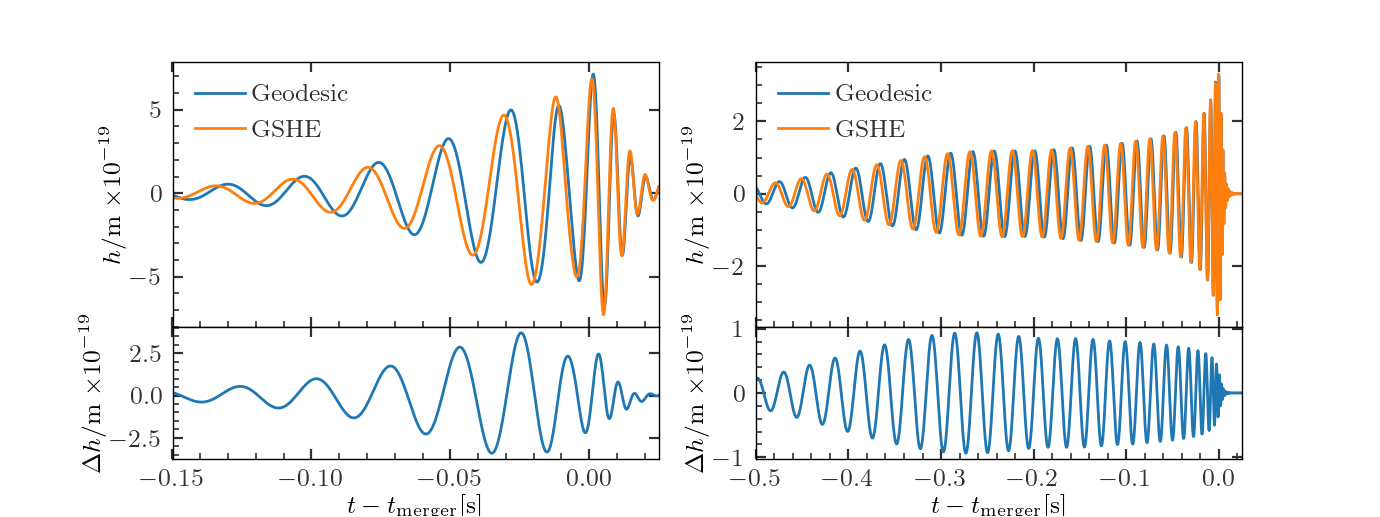

In [101]:
Fplus = -0.38
Fcross = 0.71


custom_mplstyle()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3.45*2, 0.75*3.45),
                         sharex='col',  gridspec_kw={'height_ratios': [1, 0.5]})
fig.subplots_adjust(hspace=0.0, wspace=0.2)


for i, kind in enumerate(["heavy_merger", "light_merger"]):
    data = joblib.load("../data/{}.z".format(kind))
    thplus = data["thplus"]
    thcross = data["thcross"]
    thplus_gshe = data["thplus_gshe"]
    thcross_gshe = data["thcross_gshe"]
    strain = GSHEWaveform.waveform_to_strain(thplus, thcross, Fplus, Fcross)
    strain_gshe = GSHEWaveform.waveform_to_strain(thplus_gshe, thcross_gshe, Fplus, Fcross)

    axes[0, i].plot(strain.sample_times, strain, label="Geodesic")
    axes[0, i].plot(strain_gshe.sample_times, strain_gshe, label="GSHE")
    axes[1, i].plot(strain.sample_times, strain - strain_gshe)




plt.savefig("/Users/richard/Downloads/_tmp.png")

axes[1, 0].set_xlim(-0.15, 0.025) 
axes[1, 1].set_xlim(-0.5, 0.025)


for i in range(2):
    axes[1, i].set_xlabel(r"$t - t_{\rm merger} [\mathrm{s}]$")
    ylabel_with_offset(axes[0, i], r"$h / \mathrm{m}$")
    ylabel_with_offset(axes[1, i], r"$\Delta h / \mathrm{m}$")
    axes[0,i].legend()

plt.savefig("/Users/richard/Downloads/strains.pdf", dpi=300, bbox_inches="tight")
plt.show()